In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydaptivefiltering as pdf

In [4]:
# --- 1. CONFIGURAÇÃO DO SISTEMA NÃO-LINEAR REAL ---
np.random.seed(42)
n_samples = 2500
input_dim = 2
n_neurons = 6

# Entrada real normalizada
x = np.random.randn(n_samples)
x /= np.std(x)

# Planta Desconhecida: Sistema com Saturação e Memória
# d[k] = 0.8 * tanh(x[k] + 0.5*x[k-1]) + ruído
d = np.zeros(n_samples)
for k in range(1, n_samples):
    z = x[k] + 0.6 * x[k-1]
    d[k] = 0.8 * np.tanh(z) + 0.1 * (z**2) # Não-linearidade assimétrica

# Adiciona ruído branco
d += 0.03 * np.random.randn(n_samples)

# --- 2. EXECUÇÃO DO FILTRO RBF ---
# Passos de adaptação conservadores para garantir estabilidade
filt = pdf.RBF(
    n_neurons=n_neurons,
    input_dim=input_dim,
    ur=0.001,      # Step-size dos centros (lento)
    uw=0.02,       # Step-size dos pesos (mais rápido)
    us=0.0001,     # Step-size do sigma (muito sensível)
    sigma_init=1.2,
    safe_eps=1e-6
)

result = filt.optimize(x, d, verbose=True, return_internal_states=True)

[RBF] Completed in 66.096 ms


<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'
C:\Users\bruno\AppData\Local\Temp\ipykernel_24696\1275965918.py:35: SyntaxWarning: invalid escape sequence '\s'
  ax4.set_title("Largura Final dos Kernels ($\sigma_i$)")


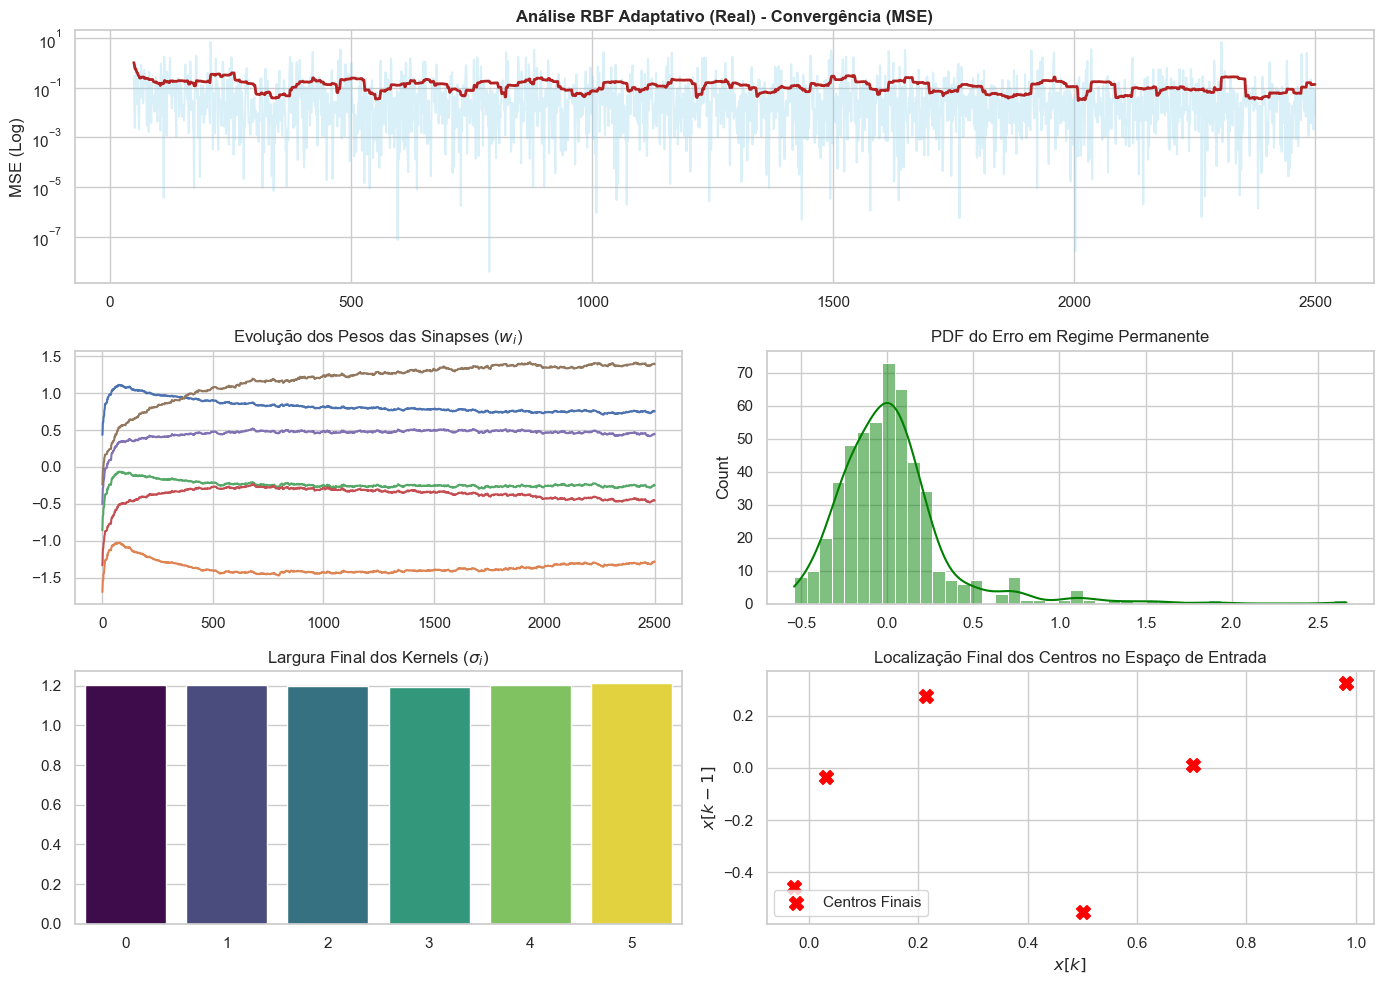

In [6]:
# --- 3. VISUALIZAÇÃO DOS RESULTADOS ---

def plot_rbf_real_results(result, title):
    sns.set_theme(style="whitegrid")
    mse = result.mse()
    t = np.arange(len(mse))
    
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2)

    # A. Curva de Aprendizado (MSE)
    ax1 = fig.add_subplot(gs[0, :])
    sns.lineplot(x=t[50:], y=mse[50:], ax=ax1, color="skyblue", alpha=0.3)
    mse_smooth = pd.Series(mse).rolling(window=50).mean()
    sns.lineplot(x=t[50:], y=mse_smooth[50:], ax=ax1, color="firebrick", lw=2)
    ax1.set_yscale('log')
    ax1.set_title(f"{title} - Convergência (MSE)", fontweight='bold')
    ax1.set_ylabel("MSE (Log)")

    # B. Evolução dos Pesos de Saída
    ax2 = fig.add_subplot(gs[1, 0])
    w_hist = result.coefficients[1:]
    ax2.plot(t, w_hist)
    ax2.set_title("Evolução dos Pesos das Sinapses ($w_i$)")

    # C. Distribuição do Erro Residual
    ax3 = fig.add_subplot(gs[1, 1])
    sns.histplot(result.errors[-500:], kde=True, ax=ax3, color="green")
    ax3.set_title("PDF do Erro em Regime Permanente")

    # D. Espalhamentos Finais (Sigma)
    ax4 = fig.add_subplot(gs[2, 0])
    sigmas = result.extra["sigma_last"]
    sns.barplot(x=list(range(len(sigmas))), y=sigmas, ax=ax4, hue=list(range(len(sigmas))), palette="viridis", legend=False)
    ax4.set_title("Largura Final dos Kernels ($\sigma_i$)")

    # E. Movimentação dos Centros (Projeção 2D)
    ax5 = fig.add_subplot(gs[2, 1])
    centers = result.extra["centers_last"]
    ax5.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=100, label='Centros Finais')
    ax5.set_title("Localização Final dos Centros no Espaço de Entrada")
    ax5.set_xlabel("$x[k]$")
    ax5.set_ylabel("$x[k-1]$")
    ax5.legend()

    plt.tight_layout()
    plt.show()

plot_rbf_real_results(result, "Análise RBF Adaptativo (Real)")

In [12]:
def plot_advanced_diagnostic(result, title="Análise de Performance"):
    sns.set_theme(style="whitegrid", palette="muted")
    
    # Extração robusta de dados
    mse = result.mse()
    err = result.errors
    out = result.outputs
    # Acessando o atributo diretamente (garantido pelo _pack_results da base)
    runtime = getattr(result, 'runtime_s', 0) 
    
    t = np.arange(len(mse))
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle(title, fontsize=20, fontweight='bold', y=0.95)
    gs = fig.add_gridspec(3, 3)

    # --- 1. MSE ---
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.semilogy(t, mse, alpha=0.2, color='dodgerblue')
    mse_smooth = pd.Series(mse).rolling(window=max(1, len(mse)//50)).mean()
    ax1.semilogy(t, mse_smooth, color='navy', lw=2)
    ax1.set_title("Convergência do MSE (Escala Log)")

    # --- 2. PDF DO ERRO ---
    ax2 = fig.add_subplot(gs[0, 2])
    steady_state_err = err[-int(len(err)*0.2):].real
    sns.histplot(steady_state_err, kde=True, ax=ax2, color="crimson")
    ax2.set_title("PDF do Erro (Regime Permanente)")

    # --- 3. COEFICIENTES ---
    ax3 = fig.add_subplot(gs[1, :2])
    # result.coefficients é uma lista, convertemos para array para plotar
    coeffs = np.array(result.coefficients)
    for i in range(min(coeffs.shape[1], 8)):
        ax3.plot(t, coeffs[1:, i].real, label=f'$w_{i}$')
    ax3.set_title("Evolução dos Coeficientes")
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # --- 4. AUTOCORRELAÇÃO ---
    ax4 = fig.add_subplot(gs[1, 2])
    lags = 50
    # Normalização manual da autocorrelação
    c = np.correlate(steady_state_err - np.mean(steady_state_err), 
                     steady_state_err - np.mean(steady_state_err), mode='full')
    c = c[len(c)//2 : len(c)//2 + lags]
    ax4.stem(range(lags), c / c[0])
    ax4.set_title("Autocorrelação do Erro")

    # --- 5. ERRO VS SAÍDA ---
    ax5 = fig.add_subplot(gs[2, 0])
    ax5.scatter(out[-500:].real, err[-500:].real, alpha=0.4, s=12, c='teal')
    ax5.set_title("Erro vs. Saída (Independência)")

    # --- 6. INFO BOX (CORRIGIDO) ---
    ax6 = fig.add_subplot(gs[2, 1:])
    ax6.axis('off')
    
    # Calculando MSE final em dB
    final_mse_db = 10 * np.log10(np.mean(mse[-100:]))
    
    stats_text = (
        f"--- Métricas de Performance ---\n"
        f"Final MSE: {final_mse_db:.2f} dB\n"
        f"Erro Médio: {np.mean(err[-100:]).real:.2e}\n"
        f"Tempo de Execução: {runtime*1000:.1f} ms\n"
        f"Status: {'DIVERGIU' if np.isnan(mse).any() or np.isinf(mse).any() else 'OK'}"
    )
    ax6.text(0.1, 0.5, stats_text, fontsize=15, family='monospace', 
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='navy', pad=10))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

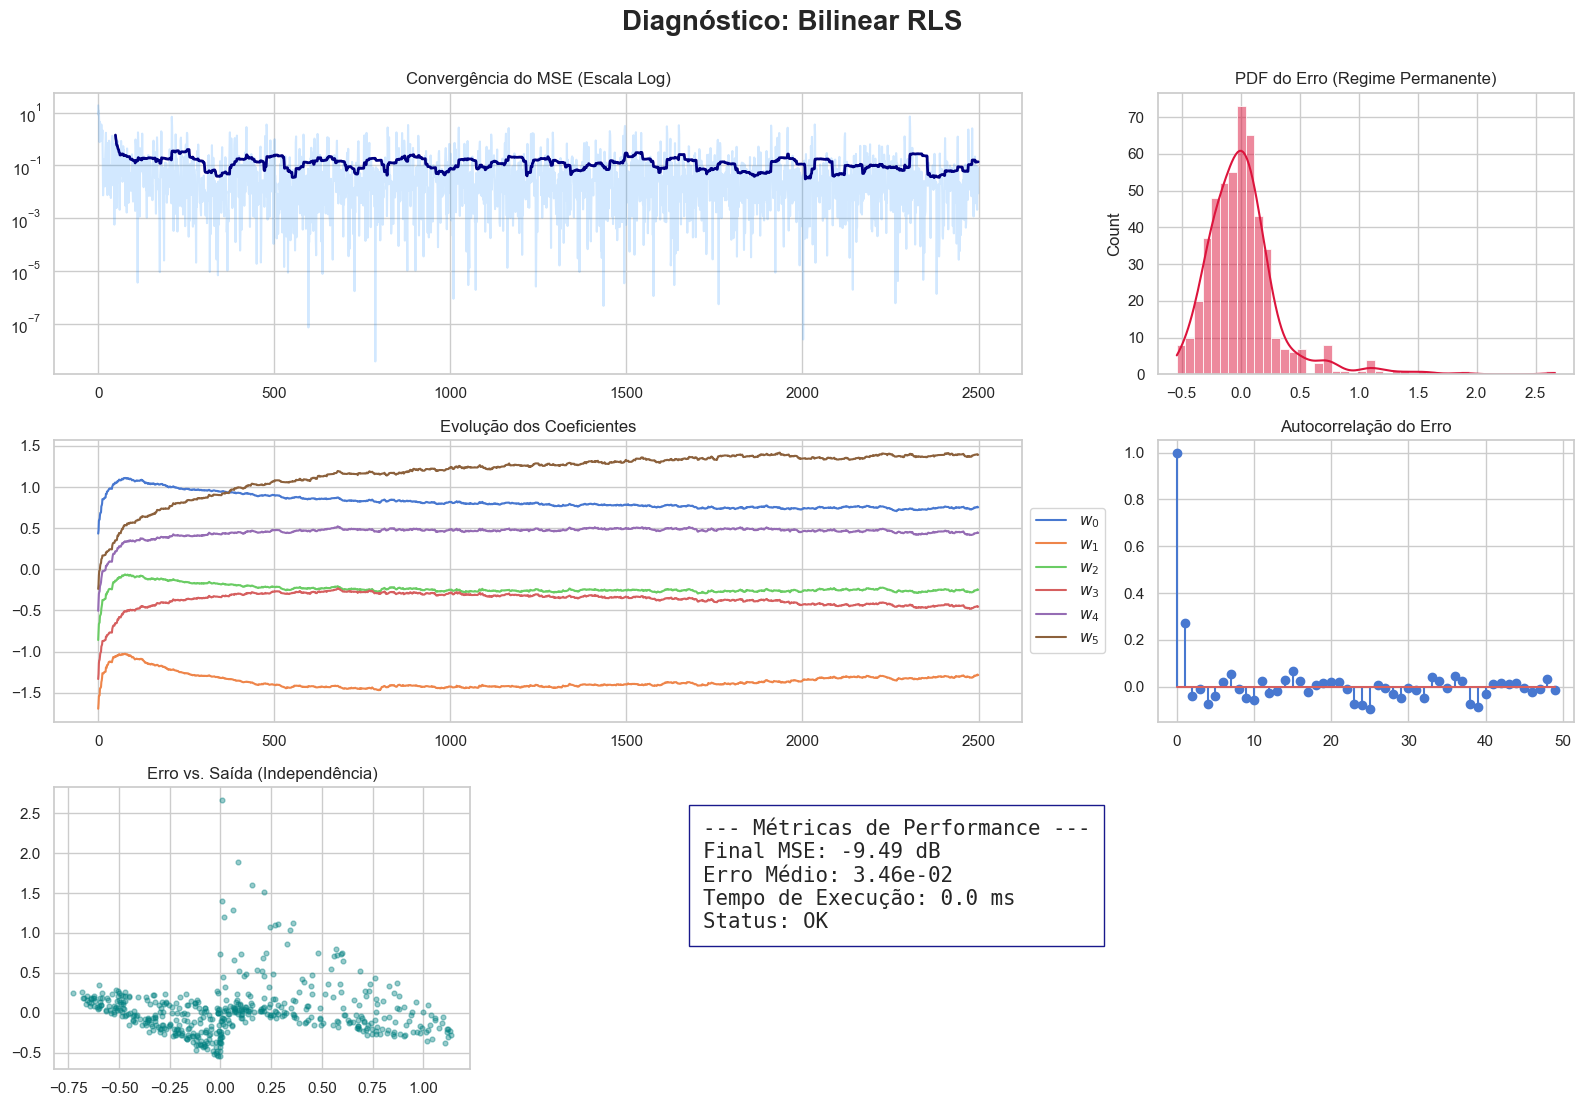

In [14]:
# Para usar:
plot_advanced_diagnostic(result, title="Diagnóstico: Bilinear RLS")